# 🏆 Challenge 2: How Do Regulations Impact Job Outcomes?

## World Bank Data Hackathon Analysis

**Research Question:** Which regulatory reforms (business entry, trade, electricity, taxes) most improve hiring, reduce skills constraints, boost formalization, and support employment outcomes?

---

### Analytical Framework

```
B-READY Regulatory Quality  ──────►  Employment Outcomes
     (Pillar I Scores)                  (Firm & Labor)
           │                                  │
           ▼                                  ▼
    • Business Entry              • Vulnerable Employment
    • Labor Regulations           • Finance Constraints
    • Financial Services          • Labor Constraints  
    • Trade Regulations           • Training Rates
    • Utility Services            • Quality Certification
    • Taxation                    • Trade Constraints
```

---

## 📦 Phase 1: Setup & Configuration

In [ ]:
# Install required packages (run once)
# !pip install pandas numpy statsmodels scipy matplotlib seaborn openpyxl plotly kaleido

In [2]:
# Core imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import warnings
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', '{:.3f}'.format)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print("✓ All packages loaded successfully!")

✓ All packages loaded successfully!


In [3]:
# ═══════════════════════════════════════════════════════════════
# CONFIGURATION - UPDATE THESE PATHS FOR YOUR MACHINE!
# ═══════════════════════════════════════════════════════════════

DATA_DIR = r"C:\Users\wb636273\Downloads"

FILES = {
    'es_wide': f"{DATA_DIR}/WB_ES_WIDEF.csv",
    'bready': f"{DATA_DIR}/BREADY_CLEAN(Sheet1).csv",
    'vulnerable_emp': f"{DATA_DIR}/Share_vulnerable_job.csv",
    'gdp_pc': f"{DATA_DIR}/gdp_per_capita_current.csv",
    'trade': f"{DATA_DIR}/trade_percentage_gdp.csv",
    'wage_bill': f"{DATA_DIR}/wage_bill_percentage_gdp.csv",
    'business_owners': f"{DATA_DIR}/number_business_owner.csv",
    'entrepreneurship': f"{DATA_DIR}/GCI 4.0-Entrepreneurial culture.csv"
}

# Create output directory
OUTPUT_DIR = f"{DATA_DIR}/hackathon_output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"📁 Data directory: {DATA_DIR}")
print(f"📁 Output directory: {OUTPUT_DIR}")

# Verify files exist
print("\n📋 File verification:")
for name, path in FILES.items():
    exists = os.path.exists(path)
    status = "✓" if exists else "✗"
    print(f"   {status} {name}: {os.path.basename(path)}")

📁 Data directory: C:\Users\wb636273\Downloads
📁 Output directory: C:\Users\wb636273\Downloads/hackathon_output

📋 File verification:
   ✓ es_wide: WB_ES_WIDEF.csv
   ✓ bready: BREADY_CLEAN(Sheet1).csv
   ✓ vulnerable_emp: Share_vulnerable_job.csv
   ✓ gdp_pc: gdp_per_capita_current.csv
   ✓ trade: trade_percentage_gdp.csv
   ✓ wage_bill: wage_bill_percentage_gdp.csv
   ✓ business_owners: number_business_owner.csv
   ✓ entrepreneurship: GCI 4.0-Entrepreneurial culture.csv


---
## 📥 Phase 2: Data Loading

### 2.1 Load B-READY Regulatory Quality Scores

In [8]:
def load_bready(filepath):
    """Load and clean B-READY regulatory quality scores"""
    
    # Try different encodings
    encodings = ['utf-8', 'latin-1', 'cp1252', 'iso-8859-1']
    
    df = None
    for encoding in encodings:
        try:
            df = pd.read_csv(filepath, encoding=encoding)
            print(f"✓ File loaded with encoding: {encoding}")
            break
        except UnicodeDecodeError:
            continue
    
    if df is None:
        raise ValueError(f"Could not read file with any of these encodings: {encodings}")
    
    # Display original structure
    print("Original columns:")
    print(df.columns.tolist())
    print(f"\nShape: {df.shape}")
    print(df.head(3))
    
    # Get column names
    cols = df.columns.tolist()
    
    # Create mapping for cleaner column names
    rename_map = {}
    
    # Find the country CODE column (3-letter ISO code, NOT the country name)
    for col in cols:
        col_lower = str(col).lower().strip()
        # Look for column named "Code" or "CountryCode" or "ISO" etc.
        if col_lower in ['code', 'countrycode', 'country_code', 'iso', 'iso3', 'country code']:
            rename_map[col] = 'country_code'
            break
    
    # If not found, check if second column contains 3-letter codes
    if 'country_code' not in rename_map.values() and len(cols) > 1:
        # Check if second column has 3-letter values (likely country codes)
        sample_val = str(df.iloc[0, 1]).strip() if len(df) > 0 else ""
        if len(sample_val) == 3 and sample_val.isalpha():
            rename_map[cols[1]] = 'country_code'
            print(f"  -> Detected country code in column: '{cols[1]}'")
    
    # Map pillar columns - order matters (more specific first)
    pillar_keywords = [
        ('Business Entry', 'reg_business_entry'),
        ('Business Location', 'reg_business_location'),
        ('Utility Services', 'reg_utilities'),
        ('Utility', 'reg_utilities'),
        ('Labor Regulations', 'reg_labor'),
        ('Labor', 'reg_labor'),
        ('Financial Services', 'reg_finance'),
        ('Financial', 'reg_finance'),
        ('International Trade', 'reg_trade'),
        ('Trade', 'reg_trade'),
        ('Taxation', 'reg_taxation'),
        ('Tax', 'reg_taxation'),
        ('Dispute Resolution', 'reg_disputes'),
        ('Dispute', 'reg_disputes'),
        ('Market Competition', 'reg_competition'),
        ('Competition', 'reg_competition'),
        ('Insolvency', 'reg_insolvency'),
    ]
    
    # Track which new names have been used to avoid duplicates
    used_names = set(rename_map.values())
    
    for col in cols:
        if col in rename_map:
            continue
            
        col_str = str(col).lower()
        
        # Check for overall Pillar 1/Regulatory Framework score
        if 'pillar' in col_str and 'regulatory' in col_str:
            if 'reg_pillar1_overall' not in used_names:
                rename_map[col] = 'reg_pillar1_overall'
                used_names.add('reg_pillar1_overall')
            continue
        
        # Check for specific pillar topics
        for keyword, new_name in pillar_keywords:
            if keyword.lower() in col_str and new_name not in used_names:
                rename_map[col] = new_name
                used_names.add(new_name)
                break
    
    print(f"\nColumn mapping applied:")
    for old, new in rename_map.items():
        old_display = old[:50] + '...' if len(str(old)) > 50 else old
        print(f"  '{old_display}' -> '{new}'")
    
    # Apply renaming
    df = df.rename(columns=rename_map)
    
    # Keep only country_code + reg_* columns
    keep_cols = ['country_code'] + [c for c in df.columns if c.startswith('reg_')]
    df = df[[c for c in keep_cols if c in df.columns]].copy()
    
    # Convert regulatory columns to numeric
    for col in df.columns:
        if col.startswith('reg_'):
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Clean country codes
    if 'country_code' in df.columns:
        df['country_code'] = df['country_code'].astype(str).str.strip().str.upper()
    
    print(f"\n✓ Final shape: {df.shape}")
    print(f"✓ Columns: {df.columns.tolist()}")
    print(f"\nFirst 5 rows:")
    print(df.head())
    
    return df


# Load B-READY data
bready = load_bready(FILES['bready'])
print(f"\n✓ Loaded B-READY: {len(bready)} countries, {len(bready.columns)-1} regulatory indicators")
print("\nSummary Statistics:")
bready.describe()

✓ File loaded with encoding: latin-1
Original columns:
['Country', 'Code', 'Pillar 1\nRegulatory Framework', 'Pillar I: Quality of Regulations for Business Entry', 'Pillar I: Quality of Regulations for Business Location', 'Pillar I: Quality of Regulations on Utility Services', 'Pillar I: Quality of Labor Regulations', 'Pillar I: Quality of Regulations for Financial Services', 'Pillar I: Quality of Regulations for International Trade', 'Pillar I: Quality of Regulations on Taxation', 'Pillar I: Quality of Regulations for Dispute Resolution', 'Pillar I: Quality of Regulations that Promote Market Competition', 'Pillar I: Quality of Regulations for Judicial Insolvency Proceedings', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32', 'Unnamed: 33',

,reg_pillar1_overall,reg_business_entry,reg_business_location,reg_utilities,reg_labor,reg_finance,reg_trade,reg_taxation,reg_disputes,reg_competition,reg_insolvency
count,50.000,50.000,50.000,50.000,50.000,50.000,50.000,50.000,50.000,50.000,50.000
mean,65.521,83.562,67.440,64.475,70.557,71.252,69.489,46.942,70.124,51.040,60.326
std,8.632,8.403,14.848,13.099,9.571,12.467,12.363,13.858,12.441,12.655,18.686
min,46.210,62.230,36.370,36.460,45.900,30.200,44.870,0.000,47.300,22.250,0.000
25%,59.120,77.860,54.315,56.655,65.035,65.025,60.570,39.032,59.390,41.148,49.930
50%,66.800,83.125,68.765,64.115,69.920,73.830,72.075,48.250,71.660,53.155,65.445
75%,72.468,90.570,80.190,74.453,77.490,77.880,79.180,54.812,79.845,61.110,72.570
max,78.340,96.610,87.580,91.740,88.230,99.440,88.920,75.000,94.590,71.600,93.170


In [9]:
# Summary statistics for B-READY
print("B-READY Regulatory Scores - Summary Statistics")
print("="*60)
bready.describe().round(2)

B-READY Regulatory Scores - Summary Statistics


,reg_pillar1_overall,reg_business_entry,reg_business_location,reg_utilities,reg_labor,reg_finance,reg_trade,reg_taxation,reg_disputes,reg_competition,reg_insolvency
count,50.000,50.000,50.000,50.000,50.000,50.000,50.000,50.000,50.000,50.000,50.000
mean,65.520,83.560,67.440,64.480,70.560,71.250,69.490,46.940,70.120,51.040,60.330
std,8.630,8.400,14.850,13.100,9.570,12.470,12.360,13.860,12.440,12.650,18.690
min,46.210,62.230,36.370,36.460,45.900,30.200,44.870,0.000,47.300,22.250,0.000
25%,59.120,77.860,54.320,56.660,65.040,65.030,60.570,39.030,59.390,41.150,49.930
50%,66.800,83.120,68.760,64.120,69.920,73.830,72.070,48.250,71.660,53.160,65.440
75%,72.470,90.570,80.190,74.450,77.490,77.880,79.180,54.810,79.840,61.110,72.570
max,78.340,96.610,87.580,91.740,88.230,99.440,88.920,75.000,94.590,71.600,93.170


### 2.2 Load Enterprise Surveys (Firm-Level Outcomes)

In [12]:
def load_enterprise_surveys(filepath):
    """Load and reshape Enterprise Surveys wide-format data"""
    
    # Try different encodings
    encodings = ['utf-8', 'latin-1', 'cp1252', 'iso-8859-1']
    
    df = None
    for encoding in encodings:
        try:
            df = pd.read_csv(filepath, encoding=encoding)
            print(f"✓ File loaded with encoding: {encoding}")
            break
        except UnicodeDecodeError:
            continue
    
    if df is None:
        raise ValueError("Could not read file")
    
    print(f"Original shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    
    # Year columns (numeric columns from 2006 onwards)
    year_cols = [c for c in df.columns if str(c).isdigit() and int(c) >= 2006]
    print(f"Year columns found: {year_cols}")
    
    # The sector info is in COMP_BREAKDOWN_1, not SECTOR
    sector_col = 'COMP_BREAKDOWN_1'
    
    if sector_col not in df.columns:
        print(f"Warning: '{sector_col}' not found. Available columns:")
        print(df.columns.tolist())
        # Try to find alternative
        for col in df.columns:
            if 'SECTOR' in col.upper() or 'BREAKDOWN' in col.upper():
                sector_col = col
                print(f"Using alternative: {sector_col}")
                break
    
    # Filter to manufacturing aggregate (SECTOR_1 = All Manufacturing)
    print(f"\nFiltering on column: {sector_col}")
    print(f"Unique values (first 10): {df[sector_col].unique()[:10]}")
    
    df_filtered = df[df[sector_col].str.contains('SECTOR_1', na=False)].copy()
    print(f"After filtering to Manufacturing-All: {len(df_filtered)} rows")
    
    # Get most recent non-null value per country-indicator
    def get_latest(row):
        for year in sorted(year_cols, reverse=True):
            val = row.get(year)
            if pd.notna(val) and str(val).strip() != '':
                try:
                    return float(val)
                except:
                    pass
        return np.nan
    
    df_filtered['latest_value'] = df_filtered.apply(get_latest, axis=1)
    
    # Pivot to wide format (one row per country)
    df_pivot = df_filtered.pivot_table(
        index='REF_AREA',
        columns='INDICATOR',
        values='latest_value',
        aggfunc='first'
    ).reset_index()
    
    df_pivot = df_pivot.rename(columns={'REF_AREA': 'country_code'})
    
    # Map indicator codes to clean variable names
    indicator_map = {
        'WB_ES_M_BREADY_WK28': 'labor_constraint',
        'WB_ES_M_BREADY_FIN33': 'finance_constraint',
        'WB_ES_M_BREADY_IN2': 'electricity_outages',
        'WB_ES_M_BREADY_IN23': 'transport_constraint',
        'WB_ES_M_BREADY_WK1': 'pct_training',
        'WB_ES_M_BREADY_T1': 'pct_quality_cert',
        'WB_ES_M_BREADY_TR26': 'trade_constraint',
        'WB_ES_M_BREADY_DISP6': 'courts_constraint',
        'WB_ES_M_BREADY_REG12': 'land_constraint',
        'WB_ES_M_BREADY_IN9': 'pct_generator',
        'WB_ES_M_BREADY_IN1_MEDIAN': 'days_electricity_conn',
        'WB_ES_M_BREADY_BUS3_MEDIAN': 'days_construction_permit',
        'WB_ES_M_BREADY_FIN26': 'pct_unfavorable_loan_terms',
        'WB_ES_M_BREADY_T11': 'pct_innovators',
        'WB_ES_M_BREADY_IN3_MEDIAN': 'outage_duration_hours',
        'WB_ES_M_BREADY_IN4_MEDIAN': 'outage_losses_pct',
    }
    
    # Apply mapping for columns that exist
    rename_cols = {k: v for k, v in indicator_map.items() if k in df_pivot.columns}
    df_pivot = df_pivot.rename(columns=rename_cols)
    
    print(f"\n✓ Final shape: {df_pivot.shape}")
    print(f"✓ Columns: {df_pivot.columns.tolist()[:15]}...")  # Show first 15
    
    return df_pivot


# Load Enterprise Surveys
es_data = load_enterprise_surveys(FILES['es_wide'])
print(f"\n✓ Loaded Enterprise Surveys: {len(es_data)} countries")
es_data.head()

✓ File loaded with encoding: utf-8
Original shape: (499427, 44)
Columns: ['FREQ', 'FREQ_LABEL', 'REF_AREA', 'REF_AREA_LABEL', 'INDICATOR', 'INDICATOR_LABEL', 'UNIT_MEASURE', 'UNIT_MEASURE_LABEL', 'COMP_BREAKDOWN_1', 'COMP_BREAKDOWN_1_LABEL', 'COMP_BREAKDOWN_2', 'COMP_BREAKDOWN_2_LABEL', 'COMP_BREAKDOWN_3', 'COMP_BREAKDOWN_3_LABEL', 'AGG_METHOD', 'AGG_METHOD_LABEL', 'DATABASE_ID', 'DATABASE_ID_LABEL', 'UNIT_MULT', 'UNIT_MULT_LABEL', 'OBS_STATUS', 'OBS_STATUS_LABEL', 'OBS_CONF', 'OBS_CONF_LABEL', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025']
Year columns found: ['2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025']

Filtering on column: COMP_BREAKDOWN_1
Unique values (first 10): ['WB_ES_M_SECTOR_1' 'WB_ES_S_SECTOR_1' 'WB_ES_S_SECTOR_13'
 'WB_ES_S_SECTOR_2' 'WB_ES_S_SECTOR

INDICATOR,country_code,days_construction_permit,WB_ES_M_BREADY_COMP1,WB_ES_M_BREADY_COMP2,WB_ES_M_BREADY_COMP3,WB_ES_M_BREADY_COMP4,WB_ES_M_BREADY_COMP5,WB_ES_M_BREADY_COMP6,WB_ES_M_BREADY_COMP7,WB_ES_M_BREADY_COMP8,WB_ES_M_BREADY_COMP9,WB_ES_M_BREADY_DISP3,WB_ES_M_BREADY_DISP4,WB_ES_M_BREADY_DISP5,courts_constraint,pct_unfavorable_loan_terms,WB_ES_M_BREADY_FIN27,WB_ES_M_BREADY_FIN28,WB_ES_M_BREADY_FIN29,WB_ES_M_BREADY_FIN30,WB_ES_M_BREADY_FIN31,WB_ES_M_BREADY_FIN32,finance_constraint,WB_ES_M_BREADY_GEND7,WB_ES_M_BREADY_IN18,...,WB_ES_T_T7_ML,WB_ES_T_T8,WB_ES_T_T9,WB_ES_T_T9_ML,WB_ES_T_TR1,WB_ES_T_TR11,WB_ES_T_TR16,WB_ES_T_TR18_U,WB_ES_T_TR2,WB_ES_T_TR21,WB_ES_T_TR22,WB_ES_T_TR23,WB_ES_T_TR24_U,WB_ES_T_TR5,WB_ES_T_TR9,WB_ES_T_WK10,WB_ES_T_WK15,WB_ES_T_WK19,WB_ES_T_WK2,WB_ES_T_WK20,WB_ES_T_WK21,WB_ES_T_WK22,WB_ES_T_WK23,WB_ES_T_WK8,WB_ES_T_WK9
0,AFG,100.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.726,53.551,NaN,NaN,NaN,NaN,NaN,NaN,56.625,NaN,NaN,...,54.367,84.317,67.742,75.345,8.111,70.990,4.708,NaN,10.599,NaN,51.026,10.599,NaN,2.601,44.323,53.146,70.748,54.934,28.976,NaN,33.036,96.205,NaN,13.484,12.960
1,AGO,30.000,76.292,3.565,32.638,63.797,72.195,11.178,65.638,60.373,78.154,28.500,24.709,16.552,25.022,62.100,56.214,70.795,0.544,0.662,69.714,0.333,68.691,0.000,21.268,...,41.188,21.223,13.088,22.970,5.569,29.580,0.790,21.593,16.546,29.580,21.661,16.546,20.178,0.474,34.644,19.548,76.052,83.587,36.081,79.505,47.006,89.095,63.043,22.260,1.991
2,ALB,30.000,NaN,5.067,29.312,65.621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.636,6.339,NaN,NaN,NaN,NaN,NaN,NaN,40.136,NaN,NaN,...,65.870,74.807,34.606,43.346,1.146,68.662,39.914,NaN,1.843,68.662,58.063,1.843,NaN,28.979,4.278,33.322,70.857,82.241,42.219,NaN,60.632,99.217,69.130,19.686,8.401
3,ARG,60.000,NaN,4.749,39.341,55.910,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.321,39.979,NaN,NaN,NaN,NaN,NaN,NaN,42.396,NaN,NaN,...,50.488,61.736,43.151,45.965,6.500,60.959,8.074,NaN,19.269,60.959,24.391,19.269,NaN,3.204,22.780,34.957,65.522,66.547,67.138,NaN,40.723,97.644,69.016,30.410,52.291
4,ARM,7.000,65.865,9.675,29.235,61.090,70.139,17.275,74.912,85.983,34.174,40.392,54.097,32.198,7.661,43.106,16.923,73.536,1.100,0.443,64.907,0.550,39.724,24.842,18.767,...,54.476,64.502,22.839,43.754,12.461,72.925,12.056,14.840,13.708,72.925,51.397,13.708,15.023,7.476,8.037,23.305,70.658,78.361,7.239,68.745,34.524,94.244,90.396,21.270,2.140


In [13]:
# Check available outcome variables
outcome_cols = [c for c in es_data.columns if c != 'country_code']
print("Available Enterprise Survey Variables:")
print("-" * 50)
for col in outcome_cols[:15]:  # Show first 15
    n_valid = es_data[col].notna().sum()
    print(f"  {col}: {n_valid} observations")

Available Enterprise Survey Variables:
--------------------------------------------------
  days_construction_permit: 163 observations
  WB_ES_M_BREADY_COMP1: 105 observations
  WB_ES_M_BREADY_COMP2: 142 observations
  WB_ES_M_BREADY_COMP3: 142 observations
  WB_ES_M_BREADY_COMP4: 142 observations
  WB_ES_M_BREADY_COMP5: 106 observations
  WB_ES_M_BREADY_COMP6: 106 observations
  WB_ES_M_BREADY_COMP7: 106 observations
  WB_ES_M_BREADY_COMP8: 106 observations
  WB_ES_M_BREADY_COMP9: 106 observations
  WB_ES_M_BREADY_DISP3: 106 observations
  WB_ES_M_BREADY_DISP4: 106 observations
  WB_ES_M_BREADY_DISP5: 106 observations
  courts_constraint: 168 observations
  pct_unfavorable_loan_terms: 168 observations


### 2.3 Load Vulnerable Employment Data

In [14]:
def load_vulnerable_employment(filepath):
    """Load ILO vulnerable employment data"""
    
    df = pd.read_csv(filepath)
    
    # Filter to country-level (3-letter codes)
    df = df[df['REF_AREA'].str.len() == 3].copy()
    
    # Get year columns
    year_cols = [c for c in df.columns if c.isdigit()]
    
    # Get most recent value
    def get_latest(row):
        for year in sorted(year_cols, reverse=True):
            val = row.get(year)
            if pd.notna(val) and str(val).strip() != '':
                try:
                    return float(val)
                except:
                    pass
        return np.nan
    
    df['vulnerable_employment'] = df.apply(get_latest, axis=1)
    
    result = df[['REF_AREA', 'vulnerable_employment']].copy()
    result = result.rename(columns={'REF_AREA': 'country_code'})
    result = result.dropna()
    
    return result

# Load vulnerable employment
vuln_emp = load_vulnerable_employment(FILES['vulnerable_emp'])
print(f"✓ Loaded Vulnerable Employment: {len(vuln_emp)} countries")
print(f"   Mean: {vuln_emp['vulnerable_employment'].mean():.1f}%")
print(f"   Range: {vuln_emp['vulnerable_employment'].min():.1f}% - {vuln_emp['vulnerable_employment'].max():.1f}%")

✓ Loaded Vulnerable Employment: 235 countries
   Mean: 37.6%
   Range: 0.1% - 93.3%


### 2.4 Load Control Variables (GDP, Trade)

In [15]:
def load_wdi_variable(filepath, var_name):
    """Load a WDI variable from long format"""
    
    df = pd.read_csv(filepath)
    
    # Filter to countries (3-letter codes)
    df = df[df['REF_AREA'].str.len() == 3].copy()
    
    # Get most recent observation
    df = df.sort_values('TIME_PERIOD', ascending=False)
    df = df.groupby('REF_AREA').first().reset_index()
    
    result = df[['REF_AREA', 'OBS_VALUE']].copy()
    result.columns = ['country_code', var_name]
    result[var_name] = pd.to_numeric(result[var_name], errors='coerce')
    
    return result

# Load GDP per capita
gdp = load_wdi_variable(FILES['gdp_pc'], 'gdp_per_capita')
gdp['ln_gdp_pc'] = np.log(gdp['gdp_per_capita'] + 1)
print(f"✓ Loaded GDP per capita: {len(gdp)} countries")

# Load Trade % GDP
trade = load_wdi_variable(FILES['trade'], 'trade_pct_gdp')
print(f"✓ Loaded Trade % GDP: {len(trade)} countries")

✓ Loaded GDP per capita: 260 countries
✓ Loaded Trade % GDP: 239 countries


---
## 🔗 Phase 3: Data Merging

In [16]:
# Merge all datasets
print("Merging datasets...")
print("=" * 50)

# Start with B-READY (our key predictors)
analysis = bready.copy()
print(f"1. B-READY base: {len(analysis)} countries")

# Add Enterprise Survey outcomes
analysis = analysis.merge(es_data, on='country_code', how='left')
print(f"2. + Enterprise Surveys: {len(analysis)} countries")

# Add vulnerable employment
analysis = analysis.merge(vuln_emp, on='country_code', how='left')
print(f"3. + Vulnerable Employment: {len(analysis)} countries")

# Add controls
analysis = analysis.merge(gdp, on='country_code', how='left')
analysis = analysis.merge(trade, on='country_code', how='left')
print(f"4. + Controls: {len(analysis)} countries")

print(f"\n✓ Final dataset: {len(analysis)} countries, {len(analysis.columns)} variables")

Merging datasets...
1. B-READY base: 51 countries
2. + Enterprise Surveys: 51 countries
3. + Vulnerable Employment: 51 countries
4. + Controls: 51 countries

✓ Final dataset: 51 countries, 555 variables


In [17]:
analysis

,country_code,reg_pillar1_overall,reg_business_entry,reg_business_location,reg_utilities,reg_labor,reg_finance,reg_trade,reg_taxation,reg_disputes,reg_competition,reg_insolvency,days_construction_permit,WB_ES_M_BREADY_COMP1,WB_ES_M_BREADY_COMP2,WB_ES_M_BREADY_COMP3,WB_ES_M_BREADY_COMP4,WB_ES_M_BREADY_COMP5,WB_ES_M_BREADY_COMP6,WB_ES_M_BREADY_COMP7,WB_ES_M_BREADY_COMP8,WB_ES_M_BREADY_COMP9,WB_ES_M_BREADY_DISP3,WB_ES_M_BREADY_DISP4,WB_ES_M_BREADY_DISP5,...,WB_ES_T_TR1,WB_ES_T_TR11,WB_ES_T_TR16,WB_ES_T_TR18_U,WB_ES_T_TR2,WB_ES_T_TR21,WB_ES_T_TR22,WB_ES_T_TR23,WB_ES_T_TR24_U,WB_ES_T_TR5,WB_ES_T_TR9,WB_ES_T_WK10,WB_ES_T_WK15,WB_ES_T_WK19,WB_ES_T_WK2,WB_ES_T_WK20,WB_ES_T_WK21,WB_ES_T_WK22,WB_ES_T_WK23,WB_ES_T_WK8,WB_ES_T_WK9,vulnerable_employment,gdp_per_capita,ln_gdp_pc,trade_pct_gdp
0,BGD,56.940,80.000,61.550,52.810,78.710,74.220,51.110,44.750,52.490,36.920,36.830,15.000,NaN,NaN,NaN,NaN,92.734,0.726,68.258,90.031,59.850,18.071,3.826,4.415,...,6.666,14.857,11.934,8.052,11.262,14.857,9.882,11.262,13.782,11.168,1.750,4.868,80.477,86.917,62.742,93.416,185.795,94.226,28.126,22.986,1.364,48.877,1941.279,7.572,26.778
1,BRB,58.770,81.850,51.380,57.430,70.850,64.940,63.170,38.500,59.070,41.100,59.420,1.000,91.895,5.205,41.704,53.091,67.011,1.147,72.444,79.907,21.766,5.344,12.824,3.746,...,4.456,78.663,27.680,6.389,7.303,78.663,53.602,7.303,9.154,9.734,8.558,5.192,61.218,88.974,70.783,68.592,41.312,98.631,98.299,26.610,1.147,19.996,20474.639,9.927,NaN
2,BIH,67.440,87.370,70.290,60.760,83.500,57.980,73.820,51.000,65.590,57.770,66.280,60.000,67.699,8.465,34.487,57.047,85.498,19.343,61.408,79.638,39.156,66.457,22.759,26.475,...,1.593,61.846,55.031,2.842,1.929,61.846,39.351,1.929,2.353,34.763,0.403,2.905,77.055,93.363,57.014,62.942,48.178,98.335,93.079,20.525,2.564,18.780,6698.041,8.810,99.974
3,BWA,65.960,96.250,53.660,51.420,73.880,81.620,74.310,35.000,79.000,56.950,57.530,3.000,66.849,1.740,18.400,79.860,75.869,9.285,81.215,61.380,53.558,37.550,34.736,32.827,...,3.375,41.892,8.528,6.415,3.581,41.892,25.352,3.581,5.401,3.581,8.448,9.200,71.013,79.550,58.332,84.733,39.124,93.074,79.566,20.892,3.653,28.785,6937.332,8.845,66.976
4,BGR,76.330,93.750,77.710,88.400,80.660,77.240,86.400,46.500,76.150,69.200,67.280,30.000,83.172,3.678,22.406,73.916,76.595,18.585,56.144,86.913,15.236,41.408,22.799,23.231,...,2.612,50.208,34.728,4.367,2.233,50.208,29.604,2.233,9.275,21.270,4.319,41.887,81.008,82.899,58.593,69.931,59.791,94.623,93.120,22.650,4.757,7.214,10089.920,9.219,109.289
5,KHM,62.830,81.560,48.140,56.560,80.660,81.870,59.970,50.130,72.580,41.290,55.560,30.000,65.289,1.565,27.074,71.361,69.460,0.000,57.391,82.797,62.420,25.427,15.909,17.386,...,8.154,85.882,30.883,20.338,8.996,85.882,67.520,8.996,20.432,29.886,0.419,0.678,86.988,88.676,71.133,96.067,329.731,99.879,75.545,12.635,0.000,52.574,2183.557,7.689,143.447
6,CAF,60.990,72.780,69.320,63.400,45.900,77.850,54.590,26.000,67.130,49.840,83.110,1.000,51.079,0.000,1.206,98.794,75.976,6.865,77.754,75.363,43.278,25.482,21.396,19.397,...,1.941,98.604,13.929,3.165,1.715,98.604,84.591,1.715,17.048,4.397,44.530,46.350,64.058,66.058,21.358,53.329,17.858,84.444,37.428,8.408,40.176,93.324,390.091,5.969,47.823
7,TCD,61.150,77.860,48.970,53.820,52.550,76.320,69.660,30.750,83.440,46.530,71.560,1.000,73.498,0.000,14.153,85.847,76.230,15.364,89.103,11.052,75.994,25.121,27.172,17.577,...,13.672,79.571,0.380,NaN,2.378,79.571,60.587,2.378,16.259,0.342,10.531,8.713,80.162,84.427,36.251,79.748,15.385,89.521,9.520,21.101,0.972,89.956,917.386,6.823,45.363
8,COL,76.600,96.610,77.980,68.960,67.440,79.140,81.950,54.000,81.250,71.600,87.060,30.000,90.715,3.833,23.489,72.678,63.429,2.628,68.187,70.013,81.037,14.533,16.240,8.903,...,7.024,50.536,10.473,11.391,17.812,50.536,18.121,17.812,24.114,4.307,8.945,15.452,66.289,75.204,84.383,74.704,60.932,94.541,92.103,22.808,9.585,43.798,6873.423,8.836,36.889
9,CRI,71.340,82.500,74.460,74.370,74.320,76.760,74.350,40.630,83.380,60.720,71.940,60.000,93.432,0.413,26.901,72.685,63.903,1.

In [18]:
# Data availability summary
print("\n📊 Data Availability Summary")
print("=" * 50)

key_vars = {
    'Regulatory Quality': ['reg_labor', 'reg_finance', 'reg_trade', 'reg_utilities', 'reg_taxation'],
    'Firm Outcomes': ['labor_constraint', 'finance_constraint', 'trade_constraint', 'pct_training'],
    'Employment': ['vulnerable_employment'],
    'Controls': ['ln_gdp_pc', 'trade_pct_gdp']
}

for category, vars_list in key_vars.items():
    print(f"\n{category}:")
    for var in vars_list:
        if var in analysis.columns:
            n = analysis[var].notna().sum()
            pct = 100 * n / len(analysis)
            print(f"   {var}: {n} obs ({pct:.0f}%)")
        else:
            print(f"   {var}: NOT AVAILABLE")


📊 Data Availability Summary

Regulatory Quality:
   reg_labor: 50 obs (98%)
   reg_finance: 50 obs (98%)
   reg_trade: 50 obs (98%)
   reg_utilities: 50 obs (98%)
   reg_taxation: 50 obs (98%)

Firm Outcomes:
   labor_constraint: 47 obs (92%)
   finance_constraint: 47 obs (92%)
   trade_constraint: 47 obs (92%)
   pct_training: 47 obs (92%)

Employment:
   vulnerable_employment: 46 obs (90%)

Controls:
   ln_gdp_pc: 47 obs (92%)
   trade_pct_gdp: 46 obs (90%)


In [19]:
# Preview the analysis dataset
analysis.head(10)

,country_code,reg_pillar1_overall,reg_business_entry,reg_business_location,reg_utilities,reg_labor,reg_finance,reg_trade,reg_taxation,reg_disputes,reg_competition,reg_insolvency,days_construction_permit,WB_ES_M_BREADY_COMP1,WB_ES_M_BREADY_COMP2,WB_ES_M_BREADY_COMP3,WB_ES_M_BREADY_COMP4,WB_ES_M_BREADY_COMP5,WB_ES_M_BREADY_COMP6,WB_ES_M_BREADY_COMP7,WB_ES_M_BREADY_COMP8,WB_ES_M_BREADY_COMP9,WB_ES_M_BREADY_DISP3,WB_ES_M_BREADY_DISP4,WB_ES_M_BREADY_DISP5,...,WB_ES_T_TR1,WB_ES_T_TR11,WB_ES_T_TR16,WB_ES_T_TR18_U,WB_ES_T_TR2,WB_ES_T_TR21,WB_ES_T_TR22,WB_ES_T_TR23,WB_ES_T_TR24_U,WB_ES_T_TR5,WB_ES_T_TR9,WB_ES_T_WK10,WB_ES_T_WK15,WB_ES_T_WK19,WB_ES_T_WK2,WB_ES_T_WK20,WB_ES_T_WK21,WB_ES_T_WK22,WB_ES_T_WK23,WB_ES_T_WK8,WB_ES_T_WK9,vulnerable_employment,gdp_per_capita,ln_gdp_pc,trade_pct_gdp
0,BGD,56.940,80.000,61.550,52.810,78.710,74.220,51.110,44.750,52.490,36.920,36.830,15.000,NaN,NaN,NaN,NaN,92.734,0.726,68.258,90.031,59.850,18.071,3.826,4.415,...,6.666,14.857,11.934,8.052,11.262,14.857,9.882,11.262,13.782,11.168,1.750,4.868,80.477,86.917,62.742,93.416,185.795,94.226,28.126,22.986,1.364,48.877,1941.279,7.572,26.778
1,BRB,58.770,81.850,51.380,57.430,70.850,64.940,63.170,38.500,59.070,41.100,59.420,1.000,91.895,5.205,41.704,53.091,67.011,1.147,72.444,79.907,21.766,5.344,12.824,3.746,...,4.456,78.663,27.680,6.389,7.303,78.663,53.602,7.303,9.154,9.734,8.558,5.192,61.218,88.974,70.783,68.592,41.312,98.631,98.299,26.610,1.147,19.996,20474.639,9.927,NaN
2,BIH,67.440,87.370,70.290,60.760,83.500,57.980,73.820,51.000,65.590,57.770,66.280,60.000,67.699,8.465,34.487,57.047,85.498,19.343,61.408,79.638,39.156,66.457,22.759,26.475,...,1.593,61.846,55.031,2.842,1.929,61.846,39.351,1.929,2.353,34.763,0.403,2.905,77.055,93.363,57.014,62.942,48.178,98.335,93.079,20.525,2.564,18.780,6698.041,8.810,99.974
3,BWA,65.960,96.250,53.660,51.420,73.880,81.620,74.310,35.000,79.000,56.950,57.530,3.000,66.849,1.740,18.400,79.860,75.869,9.285,81.215,61.380,53.558,37.550,34.736,32.827,...,3.375,41.892,8.528,6.415,3.581,41.892,25.352,3.581,5.401,3.581,8.448,9.200,71.013,79.550,58.332,84.733,39.124,93.074,79.566,20.892,3.653,28.785,6937.332,8.845,66.976
4,BGR,76.330,93.750,77.710,88.400,80.660,77.240,86.400,46.500,76.150,69.200,67.280,30.000,83.172,3.678,22.406,73.916,76.595,18.585,56.144,86.913,15.236,41.408,22.799,23.231,...,2.612,50.208,34.728,4.367,2.233,50.208,29.604,2.233,9.275,21.270,4.319,41.887,81.008,82.899,58.593,69.931,59.791,94.623,93.120,22.650,4.757,7.214,10089.920,9.219,109.289
5,KHM,62.830,81.560,48.140,56.560,80.660,81.870,59.970,50.130,72.580,41.290,55.560,30.000,65.289,1.565,27.074,71.361,69.460,0.000,57.391,82.797,62.420,25.427,15.909,17.386,...,8.154,85.882,30.883,20.338,8.996,85.882,67.520,8.996,20.432,29.886,0.419,0.678,86.988,88.676,71.133,96.067,329.731,99.879,75.545,12.635,0.000,52.574,2183.557,7.689,143.447
6,CAF,60.990,72.780,69.320,63.400,45.900,77.850,54.590,26.000,67.130,49.840,83.110,1.000,51.079,0.000,1.206,98.794,75.976,6.865,77.754,75.363,43.278,25.482,21.396,19.397,...,1.941,98.604,13.929,3.165,1.715,98.604,84.591,1.715,17.048,4.397,44.530,46.350,64.058,66.058,21.358,53.329,17.858,84.444,37.428,8.408,40.176,93.324,390.091,5.969,47.823
7,TCD,61.150,77.860,48.970,53.820,52.550,76.320,69.660,30.750,83.440,46.530,71.560,1.000,73.498,0.000,14.153,85.847,76.230,15.364,89.103,11.052,75.994,25.121,27.172,17.577,...,13.672,79.571,0.380,NaN,2.378,79.571,60.587,2.378,16.259,0.342,10.531,8.713,80.162,84.427,36.251,79.748,15.385,89.521,9.520,21.101,0.972,89.956,917.386,6.823,45.363
8,COL,76.600,96.610,77.980,68.960,67.440,79.140,81.950,54.000,81.250,71.600,87.060,30.000,90.715,3.833,23.489,72.678,63.429,2.628,68.187,70.013,81.037,14.533,16.240,8.903,...,7.024,50.536,10.473,11.391,17.812,50.536,18.121,17.812,24.114,4.307,8.945,15.452,66.289,75.204,84.383,74.704,60.932,94.541,92.103,22.808,9.585,43.798,6873.423,8.836,36.889
9,CRI,71.340,82.500,74.460,74.370,74.320,76.760,74.350,40.630,83.380,60.720,71.940,60.000,93.432,0.413,26.901,72.685,63.903,1.

In [20]:
# Save merged data
analysis.to_csv(f"{OUTPUT_DIR}/merged_analysis_data.csv", index=False)
print(f"✓ Saved merged data to: {OUTPUT_DIR}/merged_analysis_data.csv")

✓ Saved merged data to: C:\Users\wb636273\Downloads/hackathon_output/merged_analysis_data.csv


---
## 📈 Phase 4: Exploratory Data Analysis

### 4.1 Correlation Analysis

In [21]:
# Define variable groups
reg_vars = [c for c in analysis.columns if c.startswith('reg_') and analysis[c].notna().sum() > 5]
outcome_vars = ['vulnerable_employment', 'labor_constraint', 'finance_constraint', 
                'trade_constraint', 'pct_training', 'pct_quality_cert']
outcome_vars = [v for v in outcome_vars if v in analysis.columns and analysis[v].notna().sum() > 5]

print(f"Regulatory variables: {reg_vars}")
print(f"Outcome variables: {outcome_vars}")

Regulatory variables: ['reg_pillar1_overall', 'reg_business_entry', 'reg_business_location', 'reg_utilities', 'reg_labor', 'reg_finance', 'reg_trade', 'reg_taxation', 'reg_disputes', 'reg_competition', 'reg_insolvency']
Outcome variables: ['vulnerable_employment', 'labor_constraint', 'finance_constraint', 'trade_constraint', 'pct_training', 'pct_quality_cert']


In [22]:
# Calculate correlation matrix
all_vars = reg_vars + outcome_vars
corr_matrix = analysis[all_vars].corr()

# Extract regulation → outcome correlations
reg_outcome_corr = corr_matrix.loc[outcome_vars, reg_vars]

print("\n🔗 Correlations: Regulatory Quality → Outcomes")
print("=" * 60)
print(reg_outcome_corr.round(3))


🔗 Correlations: Regulatory Quality → Outcomes
                       reg_pillar1_overall  reg_business_entry  \
vulnerable_employment               -0.510              -0.462   
labor_constraint                     0.163               0.303   
finance_constraint                  -0.399              -0.215   
trade_constraint                    -0.298              -0.046   
pct_training                         0.320               0.075   
pct_quality_cert                     0.631               0.404   

                       reg_business_location  reg_utilities  reg_labor  \
vulnerable_employment                 -0.476         -0.287     -0.538   
labor_constraint                       0.159         -0.014     -0.172   
finance_constraint                    -0.441         -0.247     -0.427   
trade_constraint                      -0.290         -0.188     -0.366   
pct_training                           0.387          0.143     -0.027   
pct_quality_cert                       0.550  

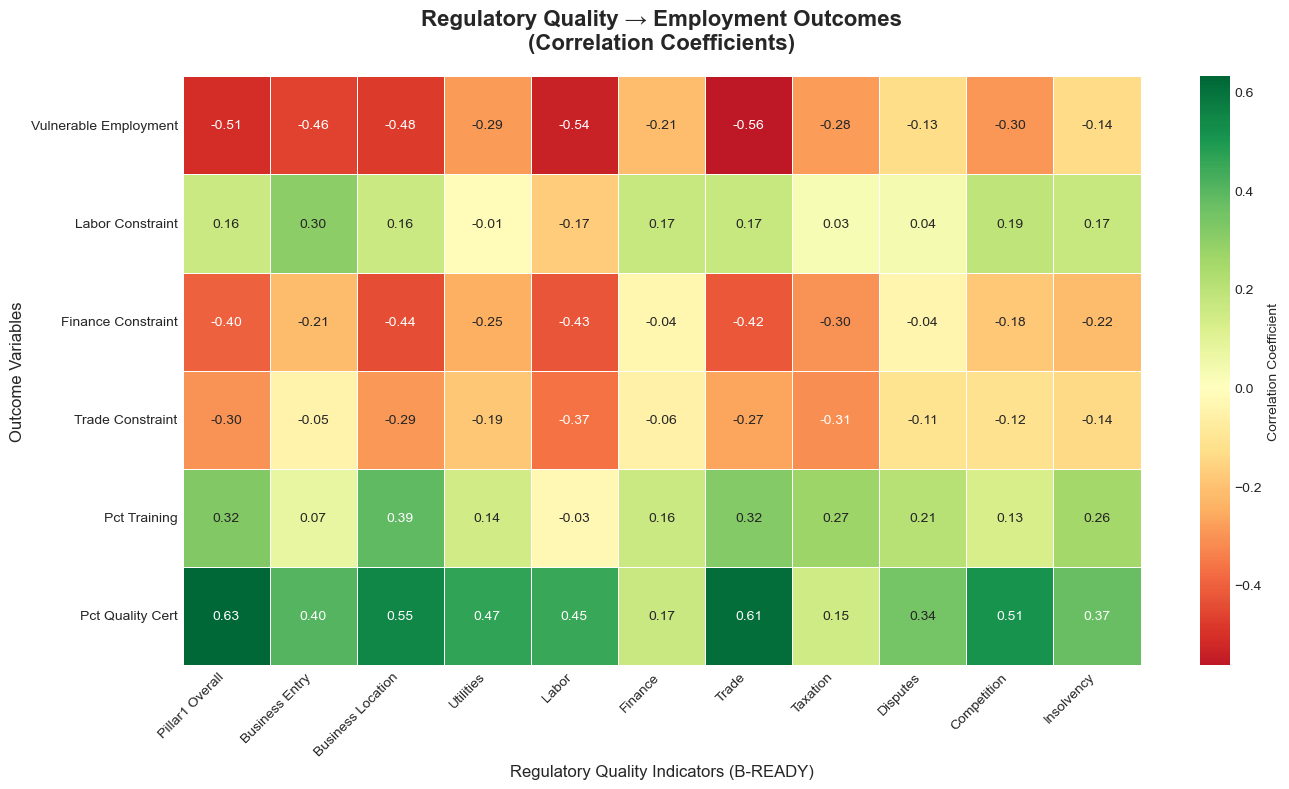


✓ Saved: fig1_correlation_heatmap.png


In [23]:
# Create correlation heatmap
fig, ax = plt.subplots(figsize=(14, 8))

sns.heatmap(reg_outcome_corr, 
            annot=True, 
            cmap='RdYlGn', 
            center=0,
            fmt='.2f', 
            ax=ax,
            cbar_kws={'label': 'Correlation Coefficient'},
            linewidths=0.5)

ax.set_title('Regulatory Quality → Employment Outcomes\n(Correlation Coefficients)', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Regulatory Quality Indicators (B-READY)', fontsize=12)
ax.set_ylabel('Outcome Variables', fontsize=12)

# Clean up labels
ax.set_xticklabels([x.replace('reg_', '').replace('_', ' ').title() for x in reg_vars], 
                   rotation=45, ha='right')
ax.set_yticklabels([y.replace('_', ' ').title() for y in outcome_vars], rotation=0)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/fig1_correlation_heatmap.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"\n✓ Saved: fig1_correlation_heatmap.png")

### 4.2 Distribution of Key Variables

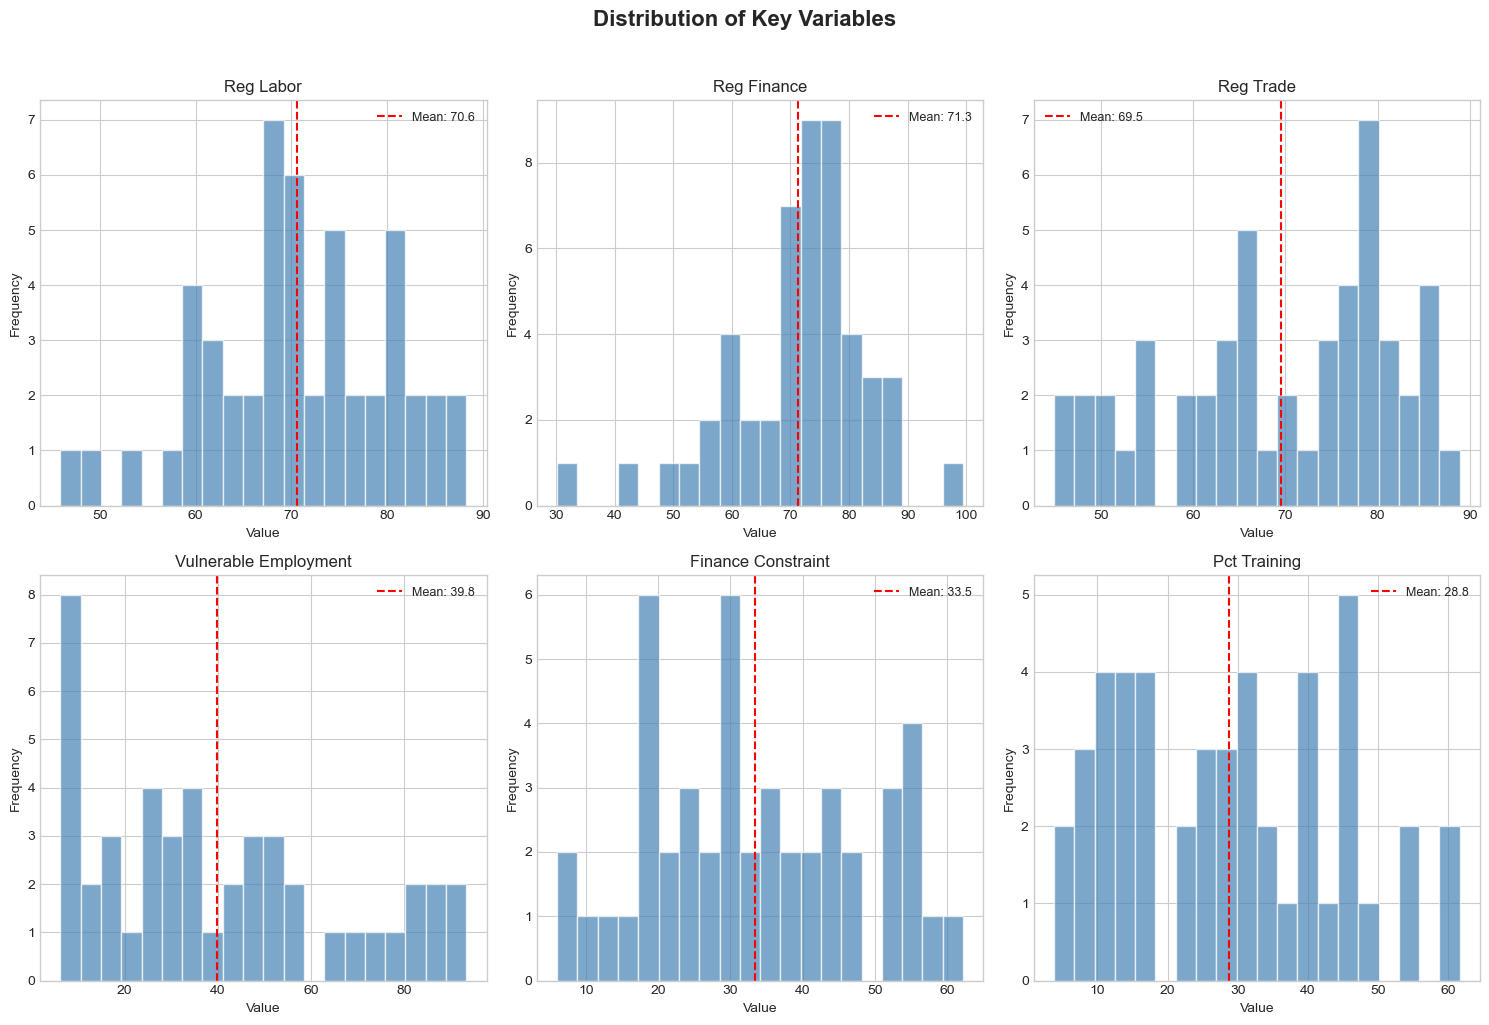

In [24]:
# Distribution plots for key variables
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

plot_vars = ['reg_labor', 'reg_finance', 'reg_trade', 
             'vulnerable_employment', 'finance_constraint', 'pct_training']
plot_vars = [v for v in plot_vars if v in analysis.columns]

for ax, var in zip(axes.flat, plot_vars):
    data = analysis[var].dropna()
    ax.hist(data, bins=20, color='steelblue', alpha=0.7, edgecolor='white')
    ax.axvline(data.mean(), color='red', linestyle='--', label=f'Mean: {data.mean():.1f}')
    ax.set_title(var.replace('_', ' ').title(), fontsize=12)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.legend(fontsize=9)

plt.suptitle('Distribution of Key Variables', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/fig2_distributions.png", dpi=150, bbox_inches='tight')
plt.show()

---
## 🎯 Phase 5: Regression Analysis

### 5.1 Model Specifications

In [25]:
# Define model specifications
MODELS = {
    'Model 1: Vulnerable Employment': {
        'y': 'vulnerable_employment',
        'x': ['reg_labor', 'reg_finance', 'reg_trade', 'reg_utilities'],
        'controls': ['ln_gdp_pc'],
        'hypothesis': 'Better regulations → Lower job vulnerability',
        'expected_sign': 'negative'
    },
    'Model 2: Finance Constraints': {
        'y': 'finance_constraint',
        'x': ['reg_finance', 'reg_business_entry', 'reg_labor'],
        'controls': ['ln_gdp_pc'],
        'hypothesis': 'Better financial regulations → Fewer finance barriers',
        'expected_sign': 'negative'
    },
    'Model 3: Labor Constraints': {
        'y': 'labor_constraint',
        'x': ['reg_labor', 'reg_business_entry'],
        'controls': ['ln_gdp_pc'],
        'hypothesis': 'Better labor regulations → Fewer labor barriers',
        'expected_sign': 'negative'
    },
    'Model 4: Training (Formalization)': {
        'y': 'pct_training',
        'x': ['reg_labor', 'reg_finance', 'reg_business_entry'],
        'controls': ['ln_gdp_pc'],
        'hypothesis': 'Better regulations → More formal training',
        'expected_sign': 'positive'
    },
    'Model 5: Trade Constraints': {
        'y': 'trade_constraint',
        'x': ['reg_trade', 'reg_utilities'],
        'controls': ['ln_gdp_pc', 'trade_pct_gdp'],
        'hypothesis': 'Better trade regulations → Fewer trade barriers',
        'expected_sign': 'negative'
    }
}

print("Model Specifications:")
print("=" * 60)
for name, spec in MODELS.items():
    print(f"\n{name}")
    print(f"   Y: {spec['y']}")
    print(f"   X: {spec['x']}")
    print(f"   Hypothesis: {spec['hypothesis']}")

Model Specifications:

Model 1: Vulnerable Employment
   Y: vulnerable_employment
   X: ['reg_labor', 'reg_finance', 'reg_trade', 'reg_utilities']
   Hypothesis: Better regulations → Lower job vulnerability

Model 2: Finance Constraints
   Y: finance_constraint
   X: ['reg_finance', 'reg_business_entry', 'reg_labor']
   Hypothesis: Better financial regulations → Fewer finance barriers

Model 3: Labor Constraints
   Y: labor_constraint
   X: ['reg_labor', 'reg_business_entry']
   Hypothesis: Better labor regulations → Fewer labor barriers

Model 4: Training (Formalization)
   Y: pct_training
   X: ['reg_labor', 'reg_finance', 'reg_business_entry']
   Hypothesis: Better regulations → More formal training

Model 5: Trade Constraints
   Y: trade_constraint
   X: ['reg_trade', 'reg_utilities']
   Hypothesis: Better trade regulations → Fewer trade barriers


### 5.2 Run Regressions

In [26]:
def run_regression(df, y_var, x_vars, controls=None, name="Model"):
    """Run OLS regression with robust standard errors"""
    
    # Combine predictors
    all_x = x_vars.copy()
    if controls:
        all_x.extend([c for c in controls if c not in all_x])
    
    # Filter to available variables
    available_x = [v for v in all_x if v in df.columns]
    
    if y_var not in df.columns:
        print(f"⚠ {name}: Outcome variable '{y_var}' not available")
        return None
    
    if len(available_x) < 1:
        print(f"⚠ {name}: No predictors available")
        return None
    
    # Prepare data
    model_vars = [y_var] + available_x
    model_df = df[model_vars].dropna()
    
    if len(model_df) < 15:
        print(f"⚠ {name}: Only {len(model_df)} observations")
        return None
    
    # Fit model
    y = model_df[y_var]
    X = sm.add_constant(model_df[available_x])
    
    model = sm.OLS(y, X).fit(cov_type='HC1')  # Robust SE
    
    return {
        'model': model,
        'y_var': y_var,
        'x_vars': available_x,
        'n_obs': len(model_df),
        'r2': model.rsquared,
        'r2_adj': model.rsquared_adj
    }

# Run all models
results = {}

print("\n" + "=" * 70)
print("REGRESSION RESULTS")
print("=" * 70)

for name, spec in MODELS.items():
    result = run_regression(
        analysis, 
        spec['y'], 
        spec['x'], 
        spec['controls'],
        name
    )
    
    if result:
        results[name] = result
        model = result['model']
        
        print(f"\n{'─' * 70}")
        print(f"📊 {name}")
        print(f"{'─' * 70}")
        print(f"Hypothesis: {spec['hypothesis']}")
        print(f"N = {result['n_obs']}, R² = {result['r2']:.3f}, Adj R² = {result['r2_adj']:.3f}")
        print(f"\nCoefficients:")
        print(f"{'Variable':<25} {'Coef':>10} {'Std Err':>10} {'p-value':>10} {'Sig':>5}")
        print("-" * 65)
        
        for var in result['x_vars']:
            coef = model.params[var]
            se = model.bse[var]
            pval = model.pvalues[var]
            sig = '***' if pval < 0.01 else '**' if pval < 0.05 else '*' if pval < 0.10 else ''
            print(f"{var:<25} {coef:>10.4f} {se:>10.4f} {pval:>10.4f} {sig:>5}")


REGRESSION RESULTS

──────────────────────────────────────────────────────────────────────
📊 Model 1: Vulnerable Employment
──────────────────────────────────────────────────────────────────────
Hypothesis: Better regulations → Lower job vulnerability
N = 46, R² = 0.743, Adj R² = 0.711

Coefficients:
Variable                        Coef    Std Err    p-value   Sig
-----------------------------------------------------------------
reg_labor                    -0.4791     0.2176     0.0277    **
reg_finance                  -0.1123     0.1691     0.5066      
reg_trade                    -0.0717     0.2253     0.7502      
reg_utilities                 0.0870     0.1496     0.5609      
ln_gdp_pc                   -15.4148     2.1868     0.0000   ***

──────────────────────────────────────────────────────────────────────
📊 Model 2: Finance Constraints
──────────────────────────────────────────────────────────────────────
Hypothesis: Better financial regulations → Fewer finance barriers
N

### 5.3 Coefficient Comparison Plot

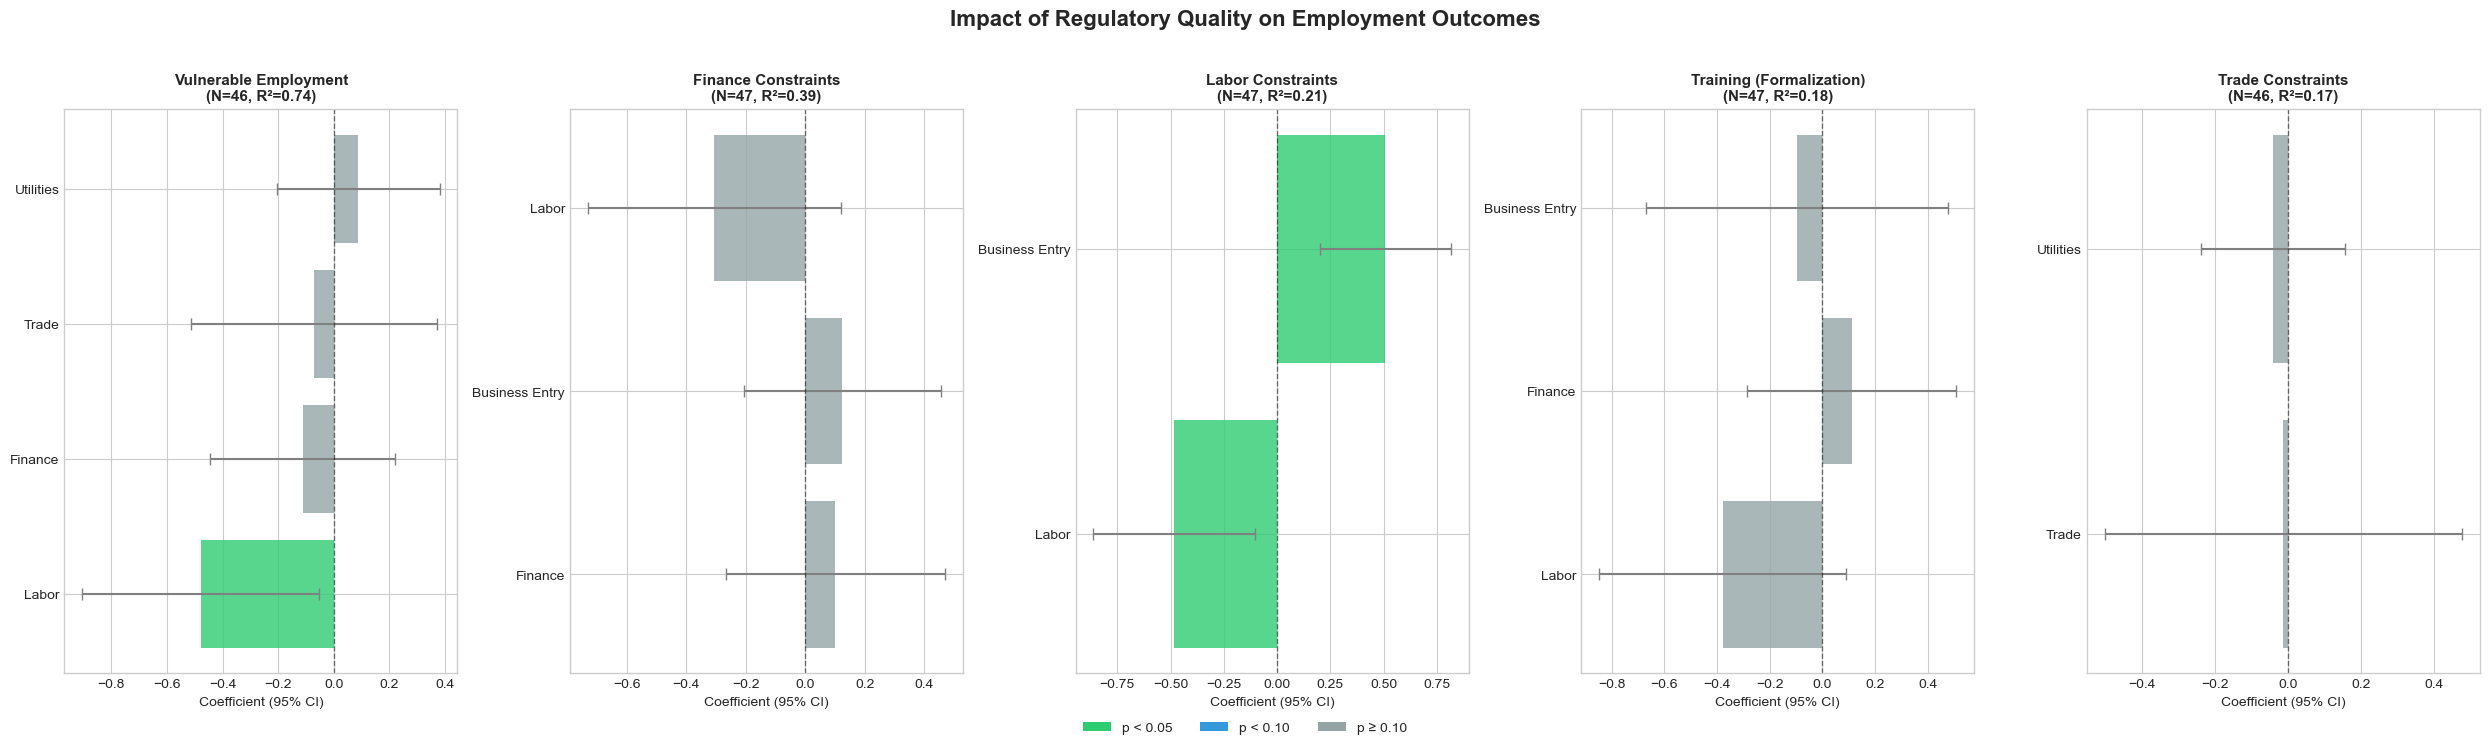


✓ Saved: fig3_coefficient_plot.png


In [27]:
# Create coefficient comparison plot
n_models = len(results)
if n_models > 0:
    fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 7))
    
    if n_models == 1:
        axes = [axes]
    
    for ax, (name, result) in zip(axes, results.items()):
        model = result['model']
        
        # Get regulatory variables only
        reg_vars_model = [v for v in result['x_vars'] if v.startswith('reg_')]
        
        if not reg_vars_model:
            continue
        
        coefs = [model.params[v] for v in reg_vars_model]
        errors = [1.96 * model.bse[v] for v in reg_vars_model]
        pvals = [model.pvalues[v] for v in reg_vars_model]
        
        # Color by significance
        colors = ['#2ecc71' if p < 0.05 else '#3498db' if p < 0.10 else '#95a5a6' 
                  for p in pvals]
        
        y_pos = range(len(reg_vars_model))
        
        ax.barh(y_pos, coefs, xerr=errors, color=colors, alpha=0.8, 
                capsize=4, ecolor='gray')
        ax.axvline(x=0, color='black', linestyle='--', alpha=0.5, linewidth=1)
        
        ax.set_yticks(y_pos)
        ax.set_yticklabels([v.replace('reg_', '').replace('_', ' ').title() 
                           for v in reg_vars_model])
        
        # Add title with stats
        short_name = name.replace('Model ', '').split(':')[1].strip() if ':' in name else name
        ax.set_title(f"{short_name}\n(N={result['n_obs']}, R²={result['r2']:.2f})", 
                    fontsize=11, fontweight='bold')
        ax.set_xlabel('Coefficient (95% CI)')
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#2ecc71', label='p < 0.05'),
        Patch(facecolor='#3498db', label='p < 0.10'),
        Patch(facecolor='#95a5a6', label='p ≥ 0.10')
    ]
    fig.legend(handles=legend_elements, loc='upper center', ncol=3, 
               bbox_to_anchor=(0.5, 0.02), fontsize=10)
    
    plt.suptitle('Impact of Regulatory Quality on Employment Outcomes', 
                fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/fig3_coefficient_plot.png", dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\n✓ Saved: fig3_coefficient_plot.png")

### 5.4 Key Relationship Scatter Plot

In [28]:
# Find the most significant regulatory effect
best_effect = None
best_pval = 1.0

for name, result in results.items():
    model = result['model']
    for var in result['x_vars']:
        if var.startswith('reg_') and model.pvalues[var] < best_pval:
            best_pval = model.pvalues[var]
            best_effect = {
                'model_name': name,
                'predictor': var,
                'outcome': result['y_var'],
                'coef': model.params[var],
                'pval': model.pvalues[var]
            }

if best_effect:
    print(f"\n🏆 Most Significant Regulatory Effect:")
    print(f"   {best_effect['predictor']} → {best_effect['outcome']}")
    print(f"   Coefficient: {best_effect['coef']:.4f}")
    print(f"   p-value: {best_effect['pval']:.4f}")


🏆 Most Significant Regulatory Effect:
   reg_business_entry → labor_constraint
   Coefficient: 0.5077
   p-value: 0.0012


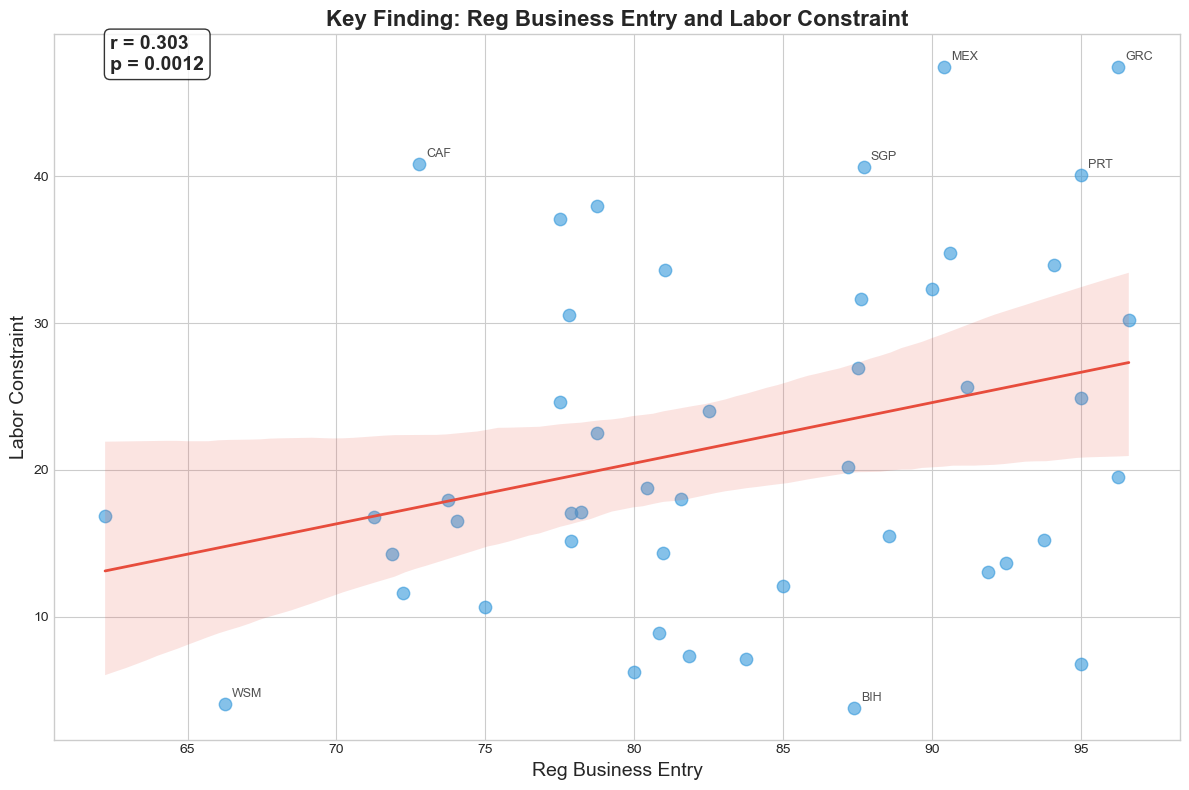


✓ Saved: fig4_key_relationship.png


In [29]:
# Create scatter plot for best predictor
if best_effect:
    x_var = best_effect['predictor']
    y_var = best_effect['outcome']
    
    plot_df = analysis[['country_code', x_var, y_var]].dropna()
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Scatter plot with regression line
    sns.regplot(data=plot_df, x=x_var, y=y_var, ax=ax,
                scatter_kws={'s': 80, 'alpha': 0.6, 'color': '#3498db'},
                line_kws={'color': '#e74c3c', 'linewidth': 2})
    
    # Add correlation annotation
    r = plot_df[x_var].corr(plot_df[y_var])
    ax.annotate(f'r = {r:.3f}\np = {best_effect["pval"]:.4f}', 
                xy=(0.05, 0.95), xycoords='axes fraction',
                fontsize=14, fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Label notable countries
    y_mean = plot_df[y_var].mean()
    y_std = plot_df[y_var].std()
    
    for _, row in plot_df.iterrows():
        if abs(row[y_var] - y_mean) > 1.5 * y_std:
            ax.annotate(row['country_code'], 
                       (row[x_var], row[y_var]),
                       fontsize=9, alpha=0.8,
                       xytext=(5, 5), textcoords='offset points')
    
    ax.set_xlabel(x_var.replace('_', ' ').title(), fontsize=14)
    ax.set_ylabel(y_var.replace('_', ' ').title(), fontsize=14)
    ax.set_title(f'Key Finding: {x_var.replace("_", " ").title()} and {y_var.replace("_", " ").title()}',
                fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/fig4_key_relationship.png", dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\n✓ Saved: fig4_key_relationship.png")

---
## 🏆 Phase 6: Key Findings & Summary

In [30]:
# Compile all significant effects
significant_effects = []

for name, result in results.items():
    model = result['model']
    for var in result['x_vars']:
        if var.startswith('reg_'):
            significant_effects.append({
                'Model': name.split(':')[1].strip() if ':' in name else name,
                'Regulatory Variable': var.replace('reg_', '').replace('_', ' ').title(),
                'Outcome': result['y_var'].replace('_', ' ').title(),
                'Coefficient': model.params[var],
                'p-value': model.pvalues[var],
                'Significant (p<0.10)': model.pvalues[var] < 0.10
            })

effects_df = pd.DataFrame(significant_effects)
effects_df = effects_df.sort_values('p-value')

print("\n" + "=" * 70)
print("📊 ALL REGULATORY EFFECTS (Ranked by Significance)")
print("=" * 70)
print(effects_df.to_string(index=False))


📊 ALL REGULATORY EFFECTS (Ranked by Significance)
                   Model Regulatory Variable               Outcome  Coefficient  p-value  Significant (p<0.10)
       Labor Constraints      Business Entry      Labor Constraint        0.508    0.001                  True
       Labor Constraints               Labor      Labor Constraint       -0.484    0.012                  True
   Vulnerable Employment               Labor Vulnerable Employment       -0.479    0.028                  True
Training (Formalization)               Labor          Pct Training       -0.379    0.113                 False
     Finance Constraints               Labor    Finance Constraint       -0.305    0.160                 False
     Finance Constraints      Business Entry    Finance Constraint        0.125    0.457                 False
   Vulnerable Employment             Finance Vulnerable Employment       -0.112    0.507                 False
   Vulnerable Employment           Utilities Vulnerable Emplo

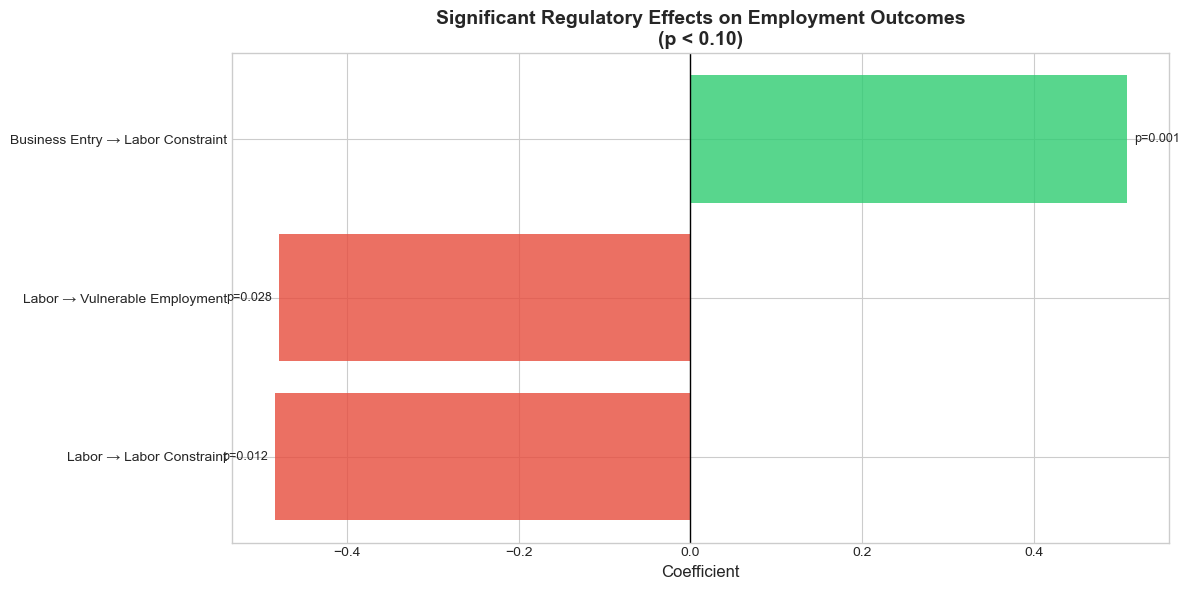


✓ Saved: fig5_significant_effects.png


In [31]:
# Summary visualization: Which regulations matter most?
sig_effects = effects_df[effects_df['Significant (p<0.10)']].copy()

if len(sig_effects) > 0:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Create labels
    sig_effects['label'] = sig_effects['Regulatory Variable'] + ' → ' + sig_effects['Outcome']
    sig_effects = sig_effects.sort_values('Coefficient')
    
    colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in sig_effects['Coefficient']]
    
    bars = ax.barh(sig_effects['label'], sig_effects['Coefficient'], color=colors, alpha=0.8)
    ax.axvline(x=0, color='black', linestyle='-', linewidth=1)
    
    ax.set_xlabel('Coefficient', fontsize=12)
    ax.set_title('Significant Regulatory Effects on Employment Outcomes\n(p < 0.10)', 
                fontsize=14, fontweight='bold')
    
    # Add value labels
    for bar, pval in zip(bars, sig_effects['p-value']):
        width = bar.get_width()
        ax.annotate(f'p={pval:.3f}',
                   xy=(width, bar.get_y() + bar.get_height()/2),
                   xytext=(5 if width > 0 else -5, 0),
                   textcoords='offset points',
                   ha='left' if width > 0 else 'right',
                   va='center', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/fig5_significant_effects.png", dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\n✓ Saved: fig5_significant_effects.png")
else:
    print("No significant effects found at p < 0.10")

---
## 💾 Phase 7: Export Results

In [33]:
# Export to Excel
with pd.ExcelWriter(f"{OUTPUT_DIR}/hackathon_results.xlsx", engine='openpyxl') as writer:
    
    # Sheet 1: Analysis data
    analysis.to_excel(writer, sheet_name='Analysis_Data', index=False)
    
    # Sheet 2: All effects
    effects_df.to_excel(writer, sheet_name='Regulatory_Effects', index=False)
    
    # Sheet 3: Correlation matrix
    reg_outcome_corr.to_excel(writer, sheet_name='Correlations')
    
    # Sheet 4: Model summaries
    model_summary = []
    for name, result in results.items():
        model_summary.append({
            'Model': name,
            'Outcome': result['y_var'],
            'N': result['n_obs'],
            'R_squared': result['r2'],
            'Adj_R_squared': result['r2_adj']
        })
    pd.DataFrame(model_summary).to_excel(writer, sheet_name='Model_Summary', index=False)

print(f"\n✓ Results exported to: {OUTPUT_DIR}/hackathon_results.xlsx")


✓ Results exported to: C:\Users\wb636273\Downloads/hackathon_output/hackathon_results.xlsx


---
## 🎤 Key Takeaways for Presentation

In [34]:
print("\n" + "=" * 70)
print("🎯 KEY FINDINGS FOR PRESENTATION")
print("=" * 70)

print(f"\n📊 Sample: {len(analysis)} countries from B-READY 2024")
print(f"📊 Models: {len(results)} regression models estimated")

# Top finding
if best_effect:
    direction = "increases" if best_effect['coef'] > 0 else "decreases"
    print(f"\n🏆 HEADLINE FINDING:")
    print(f"   Higher {best_effect['predictor'].replace('reg_', '').replace('_', ' ')} quality")
    print(f"   {direction} {best_effect['outcome'].replace('_', ' ')}")
    print(f"   Effect: {best_effect['coef']:+.3f} (p = {best_effect['pval']:.4f})")

# Policy implications
print("\n📋 POLICY IMPLICATIONS:")
sig_count = len(effects_df[effects_df['Significant (p<0.10)']])
print(f"   • {sig_count} significant regulatory effects identified")

if len(sig_effects) > 0:
    top_reg = sig_effects.iloc[0]['Regulatory Variable']
    print(f"   • Priority reform area: {top_reg}")

print("\n📁 FILES GENERATED:")
print(f"   • {OUTPUT_DIR}/hackathon_results.xlsx")
print(f"   • {OUTPUT_DIR}/fig1_correlation_heatmap.png")
print(f"   • {OUTPUT_DIR}/fig2_distributions.png")
print(f"   • {OUTPUT_DIR}/fig3_coefficient_plot.png")
print(f"   • {OUTPUT_DIR}/fig4_key_relationship.png")
print(f"   • {OUTPUT_DIR}/fig5_significant_effects.png")


🎯 KEY FINDINGS FOR PRESENTATION

📊 Sample: 51 countries from B-READY 2024
📊 Models: 5 regression models estimated

🏆 HEADLINE FINDING:
   Higher business entry quality
   increases labor constraint
   Effect: +0.508 (p = 0.0012)

📋 POLICY IMPLICATIONS:
   • 3 significant regulatory effects identified
   • Priority reform area: Labor

📁 FILES GENERATED:
   • C:\Users\wb636273\Downloads/hackathon_output/hackathon_results.xlsx
   • C:\Users\wb636273\Downloads/hackathon_output/fig1_correlation_heatmap.png
   • C:\Users\wb636273\Downloads/hackathon_output/fig2_distributions.png
   • C:\Users\wb636273\Downloads/hackathon_output/fig3_coefficient_plot.png
   • C:\Users\wb636273\Downloads/hackathon_output/fig4_key_relationship.png
   • C:\Users\wb636273\Downloads/hackathon_output/fig5_significant_effects.png


---
## ✅ Analysis Complete!

### Next Steps:
1. Review the figures in the output folder
2. Check the Excel file for detailed results
3. Prepare your 5-minute presentation

### Presentation Structure:
1. **Slide 1**: Research Question & Motivation
2. **Slide 2**: Data & Methodology 
3. **Slide 3**: Key Finding (use fig4_key_relationship.png)
4. **Slide 4**: All Significant Effects (use fig5_significant_effects.png)
5. **Slide 5**: Policy Recommendations